**Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

**Code**

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Image Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [5]:
# Data Loading (Train, Validation, Test)
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Practice/data/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Practice/data/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Practice/data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CNN(num_classes=len(train_dataset.classes)).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [6]:
# Check all the class names
class_names = train_dataset.classes
print(class_names)
print(f"Class-to-Index Mapping: {train_dataset.class_to_idx}")

['cats', 'dogs', 'snakes']
Class-to-Index Mapping: {'cats': 0, 'dogs': 1, 'snakes': 2}


**Train**

In [ ]:
# Training
def train_model(num_epochs=10, save_path='/content/best_model.pth'):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total * 100

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(valid_loader)
        val_acc = correct / total * 100

        # print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.2f}, Train Acc: {train_acc:.2f}%, "
        #       f"Val Loss: {val_loss:.2f}, Val Acc: {val_acc:.2f}%")
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)

    print("Training completed.")

# Train the model
train_model(num_epochs=10, save_path='/content/best_model.pth')

Epoch [1/10], Train Acc: 50.40%, Val Acc: 54.18%
Epoch [2/10], Train Acc: 63.93%, Val Acc: 61.65%
Epoch [3/10], Train Acc: 68.93%, Val Acc: 66.26%
Epoch [4/10], Train Acc: 75.20%, Val Acc: 71.32%
Epoch [5/10], Train Acc: 82.40%, Val Acc: 71.87%
Epoch [6/10], Train Acc: 86.93%, Val Acc: 71.76%
Epoch [7/10], Train Acc: 92.27%, Val Acc: 71.76%
Epoch [8/10], Train Acc: 94.87%, Val Acc: 71.32%
Epoch [9/10], Train Acc: 95.87%, Val Acc: 69.23%
Epoch [10/10], Train Acc: 97.47%, Val Acc: 72.42%
Training completed.


**Test**

In [ ]:
# Testing
def test_model():
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    print("Testing completed.")

# Test the model
test_model()

Test Accuracy: 69.83%
Testing completed.


**Load Model**

In [ ]:
# Load model
def load_model(path, num_classes):
    model = CNN(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(path))
    return model

# Load the trained model
model = load_model('/content/best_model.pth', num_classes=len(train_dataset.classes))
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


<ipython-input-9-49e9679de270>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


**Evaluate Model**

In [ ]:
# Evaluate model and return predictions and true labels
def evaluate_model(model, data_loader):
    model.eval()
    true_labels, predicted_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    return true_labels, predicted_labels

# Evaluate on test set
true_labels, predicted_labels = evaluate_model(model, test_loader)
print(true_labels)
print(predicted_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

**Accuracy**

['cats', 'dogs', 'snakes']

Confusion Matrix:
        cats  dogs  snakes
cats     131    52      17
dogs      62   119      19
snakes    13    18     169

Classification Report:
              precision    recall  f1-score   support

        cats       0.64      0.66      0.65       200
        dogs       0.63      0.59      0.61       200
      snakes       0.82      0.84      0.83       200

    accuracy                           0.70       600
   macro avg       0.70      0.70      0.70       600
weighted avg       0.70      0.70      0.70       600



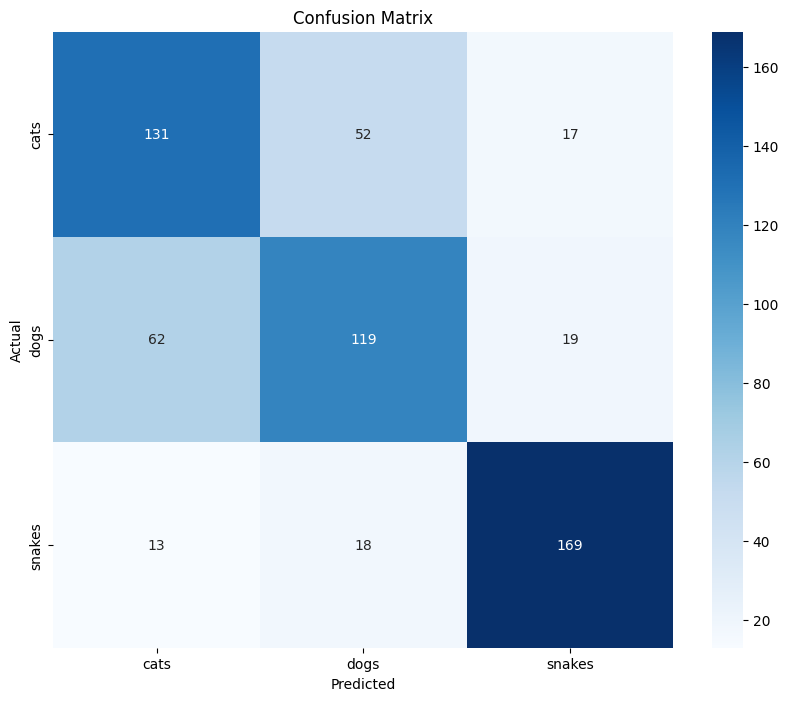

In [ ]:
# Print confusion matrix and classification report
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_names = train_dataset.classes
print(class_names)

print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# # Testing and Evaluation
# def test_and_evaluate(model, data_loader, class_names):
#     model.eval()  # Set the model to evaluation mode
#     correct, total = 0, 0
#     true_labels, predicted_labels = [], []

#     # Perform testing
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())

#     # Calculate accuracy
#     accuracy = correct / total * 100
#     print(f"Test Accuracy: {accuracy:.2f}%")

#     # Generate confusion matrix
#     conf_matrix = confusion_matrix(true_labels, predicted_labels)
#     print("\nConfusion Matrix:")
#     print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))

#     # Generate classification report
#     print("\nClassification Report:")
#     print(classification_report(true_labels, predicted_labels, target_names=class_names))

#     # Plot confusion matrix
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title('Confusion Matrix')
#     plt.show()

# # Call the function with test_loader and class names
# test_and_evaluate(model, test_loader, class_names)

**Inference**

Predicted Class: dogs


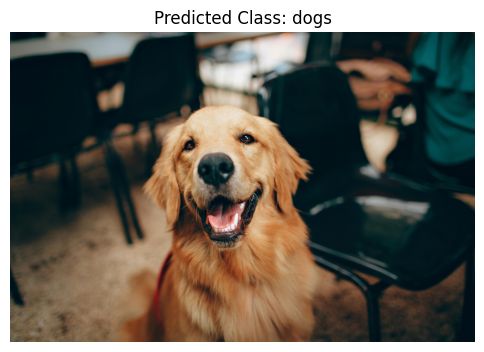

In [ ]:
# Test single image
def test_single_image(image_path, model, transform, class_names):
    try:
        # Open image and preprocess
        image = Image.open(image_path).convert("RGB")
        input_image = transform(image).unsqueeze(0).to(device)  # Transform and add batch dimension

        # Set model to evaluation mode
        model.eval()
        with torch.no_grad():
            # Get model prediction
            output = model(input_image)
            _, predicted = torch.max(output, 1)

        # Print predicted class
        predicted_class = class_names[predicted.item()]
        print(f"Predicted Class: {predicted_class}")

        # Display image
        plt.figure(figsize=(6, 6))  # Optional: Adjust size for better view
        plt.imshow(image)
        plt.title(f"Predicted Class: {predicted_class}")
        plt.axis('off')  # Hide axis
        plt.show()

    except Exception as e:
        print(f"Error: Unable to process image {image_path}. {str(e)}")

# Test on a single image
test_single_image('/content/drive/MyDrive/Practice/gyan/5.jpg', model, transform, class_names)

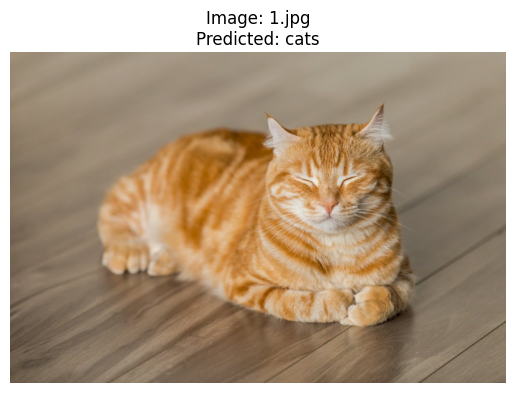

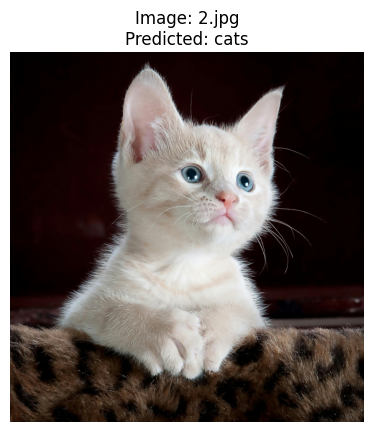

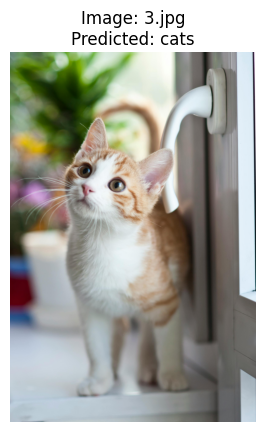

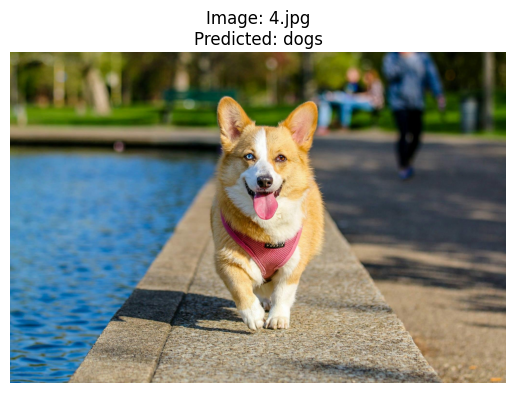

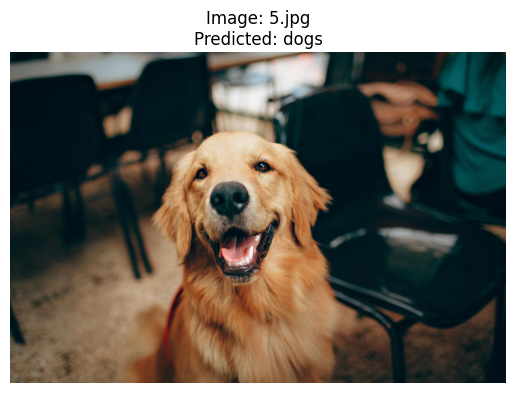

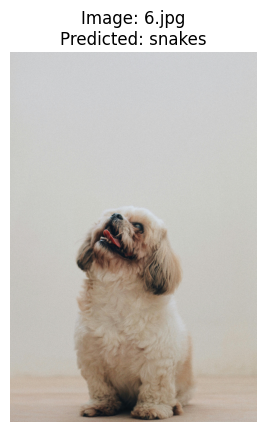

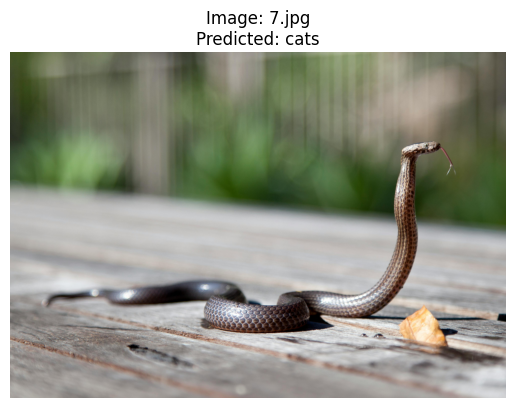

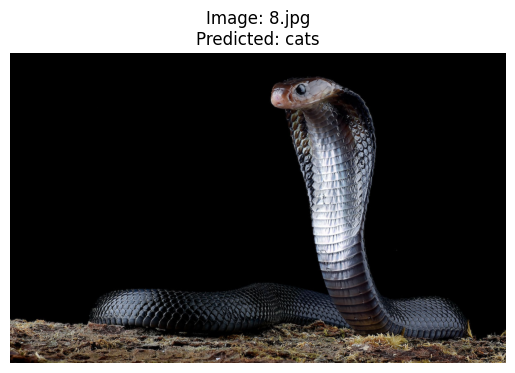

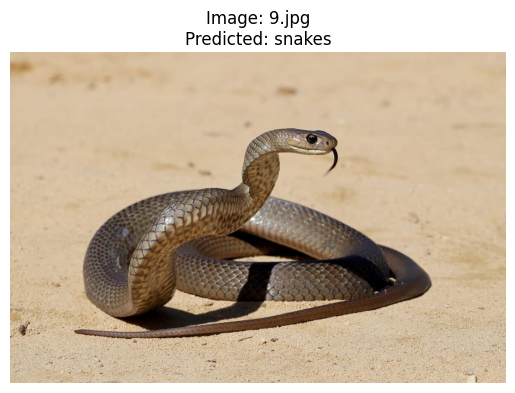

Predictions saved to /content/visualized_predictions.csv


In [ ]:
# Test and visualize all images in a folder
def test_and_visualize_images(folder_path, model, transform, class_names, save_predictions=False):
    model.eval()
    predictions = []

    # Prepare to save predictions if needed
    output_file = '/content/visualized_predictions.csv' if save_predictions else None
    if output_file and save_predictions:
        f = open(output_file, 'w')
        f.write("Image,Predicted Class\n")

    # Iterate through all images in the folder
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        try:
            # Open and preprocess the image
            image = Image.open(image_path).convert("RGB")
            input_image = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_image)
                _, predicted = torch.max(output, 1)

            predicted_class = class_names[predicted.item()]
            predictions.append((image_name, predicted_class))

            # Save prediction to file if needed
            if output_file and save_predictions:
                f.write(f"{image_name},{predicted_class}\n")

            # Visualize the image and its prediction
            plt.imshow(image)
            plt.title(f"Image: {image_name}\nPredicted: {predicted_class}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

    # Close the file if saving predictions
    if output_file and save_predictions:
        f.close()
        print(f"Predictions saved to {output_file}")

# Example usage
test_folder_path = '/content/drive/MyDrive/Practice/gyan'  # Path to the folder with test images
test_and_visualize_images(test_folder_path, model, transform, class_names, save_predictions=True)

**Visualization**

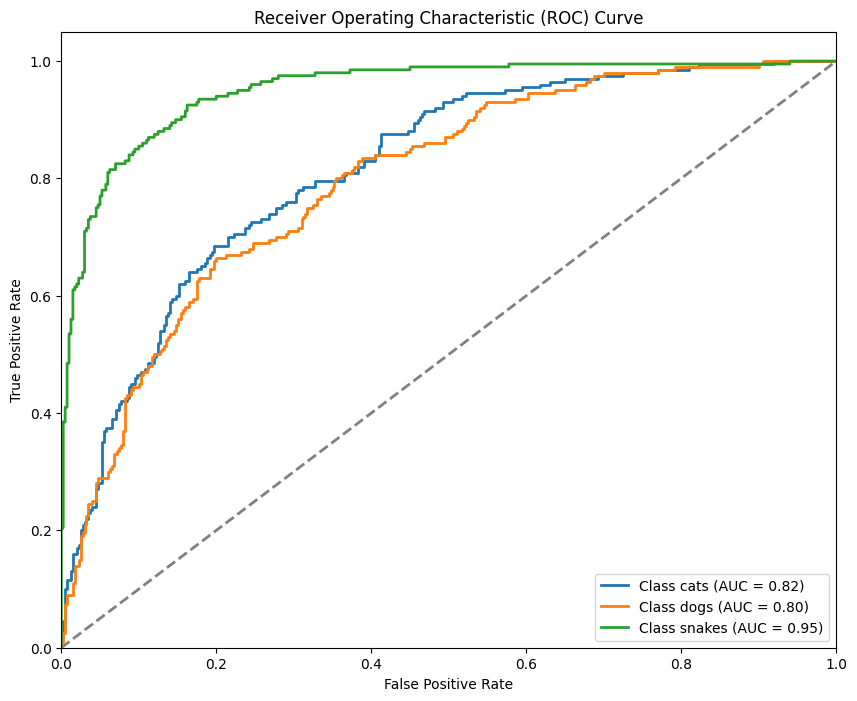

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Function to calculate and plot the ROC curve for multi-class classification
def plot_roc_curve(model, test_loader, num_classes, class_names):
    # Prepare the model for evaluation
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Convert raw outputs to probabilities using softmax
            probabilities = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probabilities.cpu().numpy())

    # Binarize the labels for multi-class classification
    all_labels = label_binarize(all_labels, classes=range(num_classes))

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], [pred[i] for pred in all_preds])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')  # Diagonal line (random classifier)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Call the function to plot the ROC curve
plot_roc_curve(model, test_loader, num_classes=len(train_dataset.classes), class_names=train_dataset.classes)